<a href="https://colab.research.google.com/github/bangkook/Face-Recognition/blob/main/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition Using PCA and LDA

---



## Introduction

This lab is intended to perform face recognition. Face recognition means that for a given image
you can tell the subject id. We use a public dataset from [kaggle](https://www.kaggle.com/). We first apply dimensionality reduction using 2 algorithms: Principal Component Analysis (PCA), and Linear Discriminant Analysis (LDA). Then, we apply a simple classifier on the reduced set of features to determine the class labels. The used classifier is the K-Neighrest Neighbour (KNN) classifier.


## Data Preparation

We used the dataset available at this [link](https://www.kaggle.com/kasikrit/att-database-of-faces/). The dataset has 10 images per 40 subjects. Every image is a grayscale image of size 92x112.

### Import modules.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Loading Data

Make sure you first upload the zip file named "archive" to ensure the following code can run.

First, unzip the file.

In [2]:
import zipfile
import io

def unzip_file(file_name):
  # Unzip the uploaded file
  with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall()

faces_zip_file = 'archive.zip'
unzip_file(faces_zip_file)


Read the data, and store it in a numpy array.

In [3]:
def read_images_dataset_into_matrix(num_rows, num_columns, data_formats_matrix):
  """
    Reads image files specified in `data_formats_matrix`.

    Parameters:
    - num_rows: The number of rows in the resulting matrix.
    - num_columns: The number of columns in the resulting matrix.
    - data_formats_matrix: A 2D list containing file paths of images arranged in rows and columns.

    Returns:
    - A NumPy array representing the dataset matrix.
    """
  dataset = []

  for row in range(num_rows):
    same_row = []

    for column in range (num_columns):
      data_item = plt.imread(data_formats_matrix[row][column])
      same_row.append(data_item)

    dataset.append(np.array(same_row))

  return np.array(dataset)

In [4]:
#Prepare data formats matrix for faces images
faces_formats_matrix = []
num_subjects = 40
num_poses = 10

for subject in range(1, num_subjects+1):
    subject_faces = []

    for pose in range(1, num_poses+1):
        data = 's' + str(subject) + '/' + str(pose) + '.pgm'
        subject_faces.append(data)

    faces_formats_matrix.append(np.array(subject_faces))


#Reading the actual faces dataset
dataset = read_images_dataset_into_matrix(num_subjects, num_poses, faces_formats_matrix)


print('Total number of subjects:', len(dataset))
print('Dataset size:', dataset.shape)

Total number of subjects: 40
Dataset size: (40, 10, 112, 92)


### Data Visualization


In [5]:
def visualise(num_rows, num_columns, data):
  # Create a subplot with the specified number of rows and columns
  fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 40))

  # Loop through the data and plot each image
  for i in range(num_rows):
      for j in range(num_columns):
          # Get the image from the data
          image = data[i, j]

          # Plot the image
          axes[i, j].imshow(image, cmap='gray')
          axes[i, j].axis('off')

  plt.tight_layout()
  plt.show()


In [6]:
def show_eigenfaces(components, image_height, image_width):
  # Displaying Eigenfaces
  fig, axes = plt.subplots(3, 8, figsize=(12, 8),
	                         subplot_kw={'xticks':[], 'yticks':[]})
  for i, ax in enumerate(axes.flat):
    ax.imshow(components[i].reshape(image_height, image_width), cmap='gray')
    ax.set_title("PC " + str(i+1))
  plt.show()

Plot images in the dataset.

In [7]:
 # visualise(num_subjects, num_poses, dataset)

### Data Matrix and Label Vector

Converting every image into a vector of 10304 values corresponding to the
image size. Then, stacking the 400 vectors into a single Data Matrix D and generating the label vector y. The labels are integers from 1:40 corresponding to the subject id.

In [8]:
def flatten_data_matrix(dataset, image_height, image_width):
    """
    Flattens the data matrix.

    Parameters:
    - dataset: The 2D data matrix.
    - image_height: The height of each image.
    - image_width: The width of each image.

    Returns:
    - Flattened data matrix.
    """

    vector_len = image_height * image_width
    num_rows, num_columns = dataset.shape[:2]
    num_images = num_rows * num_columns

    flattened_data = np.zeros((num_images, vector_len))

    for i in range(num_rows):
        for j in range(num_columns):
            image = dataset[i, j]
            vector = image.reshape(-1)

            index = i * num_columns + j
            flattened_data[index, :] = vector

    return flattened_data

In [9]:
# Reshape each image into a vector and stack them
image_height = 112
image_width = 92
y = np.repeat(np.arange(1, num_subjects + 1), num_poses)
D = flatten_data_matrix(dataset, image_height, image_width)


# Now, D contains all the image vectors stacked row by row,
# and y contains the corresponding labels for each image.
print("Shape of the data matrix D ", D.shape)
print("Shape of the label vector y ", y.shape)
# print(y)

Shape of the data matrix D  (400, 10304)
Shape of the label vector y  (400,)


### Splitting Dataset

Split the dataset into training set and test set based on the splitting ratio.

From the Data Matrix D keep the odd rows for training and the even rows for testing. This will give 5 instances per person for training and 5 instances per person for testing.

In [10]:
# Split the dataset into training and test sets
X_train = D[1::2]  # Odd rows for training
X_test = D[::2]  # Even rows for testing

# Split the labels vector accordingly
y_train = y[1::2]  # Labels for training set
y_test = y[::2]  # Labels for test set

## Classification

In [11]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier as knn
from time import time

In [12]:
## Function to perform trainig and testing with the given classifier
def classify(clf, X_train, y_train, X_test, y_test):
  clf = clf.fit(X_train, y_train) # Fit the training data

  ## Perform testing and get classification report
  t0 = time()
  y_pred = clf.predict(X_test)

  # print("done in %0.3fs" % (time() - t0))
  # print(classification_report(y_test, y_pred))

  return accuracy_score(y_test, y_pred), y_pred

### Classification using PCA


In [13]:
from scipy.sparse.linalg import eigsh
from scipy.linalg import pinv
from scipy.linalg import eig

PCA algorithm for dimensionality reduction for a given matrix D based on fractional variance alpha.

It returns the projection matrix.

**Covariance Matrix Trick:**

The reason we compute the covarinace matrix for is to obtain its eigen decomposition, so we can make a trick here to save computation time.

Instead of using 𝐗ᵀ𝐗 (d x d) , we can compute 𝐗𝐗ᵀ (n x n) then calculate its eigen decomposition. Since both matrices share the same nonzero eigenvalues. (Check **Proposition 1.4** in this [file](https://harvard-iacs.github.io/2019-CS109A/a-section/a-section4/notes/a-sec4-PCA.pdf) for a mathematical proof)

To obtain the eigenvectors of the original covariance matrix, we simple multiply the computed eigenvectors with 𝐗ᵀ.

In [14]:
def pca(D, alpha):
  n, d = D.shape
  mean = np.mean(D, axis = 0)
  Z = D - mean # Center the data
  COV = 1/n * (np.dot(np.transpose(Z), Z)) # Compute covariance matrix

  # Compute eigenvalues and eigenvectors
  # eigenvalues, U = np.linalg.eigh(COV) --> 5 mins
  eigenvalues, eigenvectors = eigsh(COV, n) # This function return eigenvalues in ascending order --> 1 min

  # Sort eigenvalues in descending order
  idx = np.argsort(eigenvalues)[::-1]
  eigenvalues = eigenvalues[idx]
  U = eigenvectors[:, idx]

  var = np.sum(eigenvalues) # Compute total variance

  # Finding principal components
  # Start with 1 dimension, and increase the number till the fraction of total
  # variance exceeds alpha (the given ratio)
  r = 0
  explained_var = 0

  while(explained_var < alpha):
    r += 1
    explained_var += eigenvalues[r-1] / var

  Ur = U[:, :r] # Reduced basis
  return mean, Ur

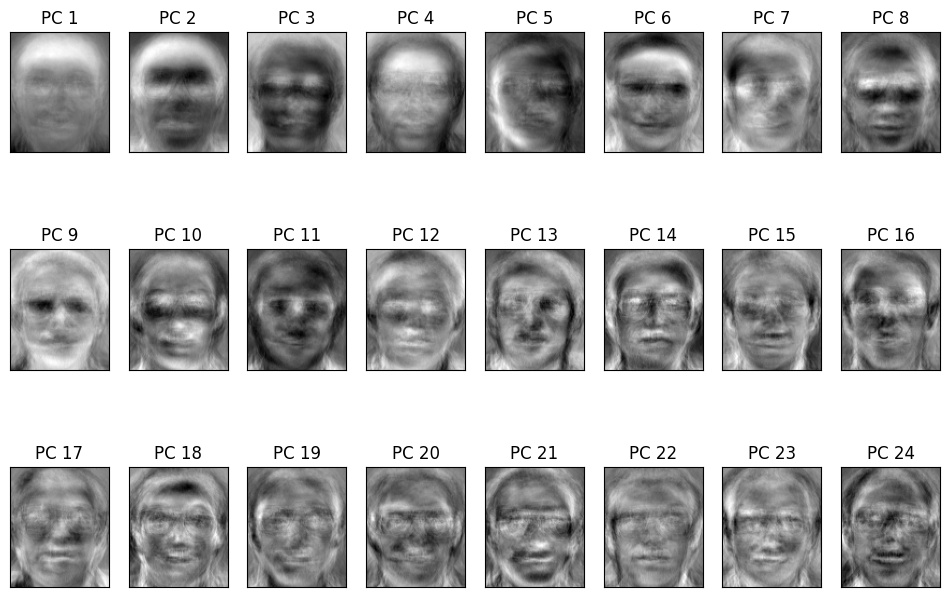

In [15]:
_, P = pca(X_train, alpha=0.8)
show_eigenfaces(np.transpose(P), image_height, image_width)

In [16]:
## Return the projected vector X by the projection matrix P
def project(X, P):
  return np.dot(X, P)

In [17]:
def get_PCA_accuracy_for_different_ks_and_alphas(X_train, X_test, y_train, y_test, alphas, k_values):
  new_dims = []
  accuracies = []
  y_pred = []
  for alpha in alphas:
    ## Compute the projection matrix using PCA
    mean, P = pca(X_train, alpha)
    new_dims.append(P.shape[1])

    # Project the training set, and test sets separately using the same projection matrix
    # after centering the data
    X_train_pca = project(X_train - mean, P)
    X_test_pca  = project(X_test  - mean, P)

    ## Initialize KNN classifier with 1 neighbour
    for k in k_values:
      clf = knn(k)
      accuracy, y_pred = classify(clf, X_train_pca, y_train, X_test_pca, y_test)
      accuracies.append(accuracy)

  return accuracies, new_dims, y_pred

In [18]:
# Define different values for alpha
alphas = [0.8, 0.85, 0.9, 0.95]

In [19]:
results, new_dims, y_pred = get_PCA_accuracy_for_different_ks_and_alphas(X_train, X_test, y_train, y_test, alphas, k_values = [1])
print(results)

[0.93, 0.94, 0.945, 0.935]


Plot the new number of dimensions aginst the value of alpha (Explained Variance)

Text(0.5, 1.0, 'Alpha Vs Number of Dimensions After Reduction')

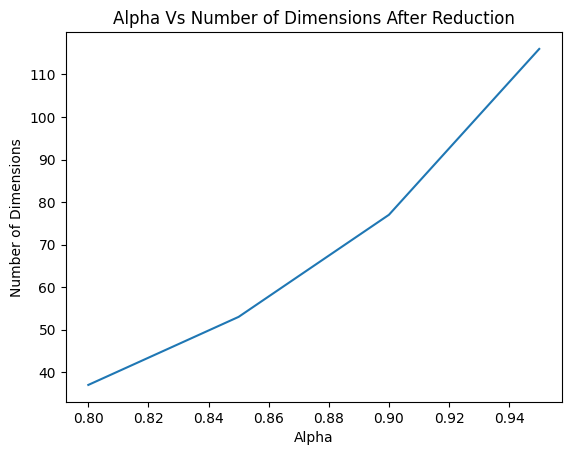

In [20]:
plt.plot(alphas, new_dims)
plt.xlabel("Alpha")
plt.ylabel("Number of Dimensions")
plt.title("Alpha Vs Number of Dimensions After Reduction")

Plot the accuracy of classification against the value of alpha

It is observed that by increasing the value of alpha, classification accuracy increases then drops at alpha = 0.95. Thus, we can't deduce a relation between alpha and accuracy. This can be for the reason that PCA is an unsupervised algorithm, so principal components do not necessarily have any correlation to classification accuracy.

There could be a 2-variable situation where 99% of the variance corresponds to the first PC but that PC has no relation to the underlying classes in the data. Whereas the second PC (which only contributes to 1% of the variance) is the one that can separate the classes. If you only keep the first PC, then you lose the feature that actually provides the ability to classify the data.

However, In practice, smaller (lower variance) PCs often are associated with noise so there can be benefit in removing them but there is no guarantee of this.

Text(0.5, 1.0, 'Alpha Vs Test Accuracy of Classififcation')

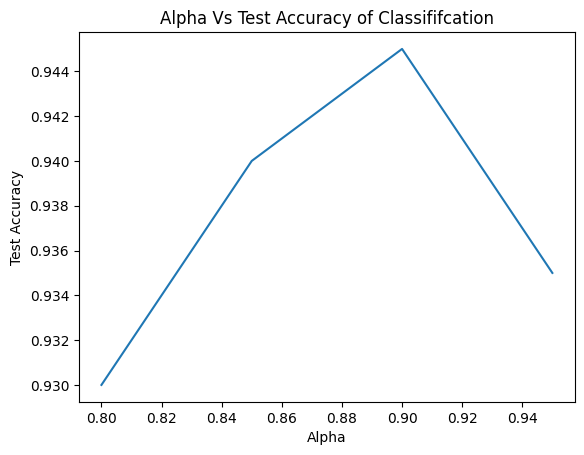

In [21]:
plt.plot(alphas, results)
plt.xlabel("Alpha")
plt.ylabel("Test Accuracy")
plt.title("Alpha Vs Test Accuracy of Classififcation")

### Classification Using LDA

a. Use the pseudo code below for LDA. We will modify few lines in pseudocode to handle multiclass LDA.

  i. Calculate the mean vector for every class Mu1, Mu2, ..., Mu40.

  ii. Replace B matrix by Sb.

    𝑆𝑏 = 𝑘=1 Σ 𝑚 𝑛𝑘(𝜇𝑘−𝜇)(𝜇𝑘−𝜇)𝑇

Here, m is the number of classes, 𝜇 is the overall sample mean, and 𝑛𝑘 is the number of samples in the k-th class.

  iii. S matrix remains the same, but it sums S1, S2, S3, ...S40.

  iv. Use 39 dominant eigenvectors instead of just one. You will have a projection matrix U39x10304.

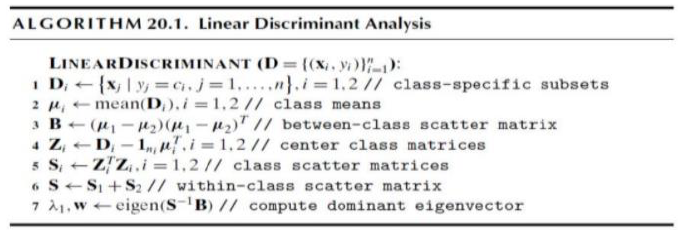

In [22]:
def lda(X_train, y_train):
    n, d = X_train.shape
   # Step 1: Calculate the mean vector for every class
    t0 = time()
    classes = np.unique(y_train)
    class_means = []
    for c in classes:
        class_means.append(np.mean(X_train[y_train == c], axis=0))
    overall_mean = np.mean(X_train, axis=0)
    print("Time of step 1 in %0.3fs" % (time() - t0))

    # Step 2: Calculate between-class scatter matrix Sb
    t0 = time()
    Sb = np.zeros((X_train.shape[1], X_train.shape[1]))
    for c, mean_vec in zip(classes, class_means):
        nk = np.sum(y_train == c)
        diff = (mean_vec - overall_mean).reshape(-1, 1)
        Sb += nk * np.dot(diff, diff.T)
    print("Time of step 2 in %0.3fs" % (time() - t0))

    # Step 3: Calculate within-class scatter matrix Sw = s1 + s2 + s3 + ....
    t0 = time()
    Sw = np.zeros((X_train.shape[1], X_train.shape[1]))
    for c, mean_vec in zip(classes, class_means):
        Xc = X_train[y_train == c]
        Zc = Xc - mean_vec
        Sw += Zc.T @ Zc
    print("Time of step 3 in %0.3fs" % (time() - t0))
    # Sw = np.cov(X_train.T)

    # Step 4: Compute eigenvalues and eigenvectors of Sw^-1 * Sb
    t0 = time()
    B = pinv(Sw) @ Sb
    #eigenvalues, eigenvectors = np.linalg.eig(B)
    eigenvalues, eigenvectors = eig(B)
    print("Time of step 4 in %0.3fs" % (time() - t0))
    eigenvectors = np.real(eigenvectors)

    # Step 5: Sort eigenvectors by eigenvalues in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Step 6: Select the first (d-1) dominant eigenvectors
    U = eigenvectors[:, :classes.size-1]  # 39 dominant eigenvectors
    return U

In [23]:
def get_LDA_accuracy_for_different_ks(X_train, X_test, y_train, y_test, k_values):
  accuracies = []
  y_pred = []
  t0 = time()
  U = lda(X_train,y_train)
  print("Time in %0.3fs" % (time() - t0))

  X_train_lda = project(X_train, U)
  X_test_lda = project(X_test, U)
  for k in k_values:
    clf = knn(k)
    accuracy, y_pred = classify(clf, X_train_lda, y_train, X_test_lda, y_test)
    accuracies.append(accuracy)
  return accuracies, y_pred

In [24]:
accuracies = get_LDA_accuracy_for_different_ks(X_train, X_test, y_train, y_test, k_values = [1])
print("LDA Accuracy : ", accuracies[0])

Time of step 1 in 0.010s
Time of step 2 in 28.633s
Time of step 3 in 37.802s
Time of step 4 in 1633.273s
Time in 1700.198s
LDA Accuracy :  [0.96]


## 6- Classifier Tuning

### *a*) Set the number of neighbors in the K-NN classifier to 1,3,5,7.

In [25]:
k_values_KNN = [1, 3, 5, 7]

### b) Tie breaking at your preferred strategy.

**Answer: We will utilize the default strategy for the built-in K-Nearest Neighbors (KNN) classifier, which resolves ties by selecting the neighbor with the lowest index among the neighbors' indices.**

### c) Plot the performance measure (accuracy) against the K value.
### This is to be done for PCA and LDA as well.

**PCA part**

In [ ]:
most_accurate_alpha = [0.9]
pca_accuracies_for_different_ks, _, _ = get_PCA_accuracy_for_different_ks_and_alphas(X_train, X_test, y_train, y_test, most_accurate_alpha, k_values_KNN)
lda_accuracies_for_different_ks,_ =  get_LDA_accuracy_for_different_ks(X_train, X_test, y_train, y_test, k_values_KNN)


**LDA part**

Text(0.5, 1.0, 'Different K-Values Vs Test Accuracy of Classififcation')

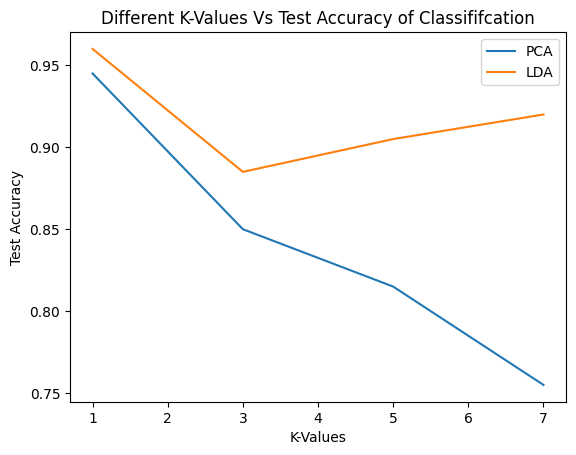

In [64]:
#Plotting the realtion between Ks and KNN-accuracy
plt.plot(k_values_KNN, pca_accuracies_for_different_ks, label = 'PCA')
plt.plot(k_values_KNN, lda_accuracies_for_different_ks, label = 'LDA')
plt.xlabel("K-Values")
plt.ylabel("Test Accuracy")
plt.legend()
plt.title("Different K-Values Vs Test Accuracy of Classififcation")

## 7- Non-faces

For non-faces model training, We used a public dataset from [Kaggle](https://www.kaggle.com/datasets/moaz123/nonfaces?select=%281%29.pgm)

**Ensure that you upload the non-faces dataset named "archive2.zip" before executing this cell.**

In [30]:
#Unzip archive2 non-faces dataset
non_faces_file_name = 'archive2.zip'
unzip_file(non_faces_file_name)

#Preparint the data formats matrix
non_faces_data_formats = []

# I want to split the data with the way of faces data like 40 rows with 10 columns in each row
num_rows = 40
num_columns = 10

for row in range(num_rows):
  same_row = []

  for col in range(1, num_columns+1):
    non_face_image_format = '(' + str((row * 10) + col) +').pgm'
    same_row.append(non_face_image_format)

  non_faces_data_formats.append(same_row)


#Read the actual non-faces dataset
non_faces_dataset = read_images_dataset_into_matrix(num_rows, num_columns, non_faces_data_formats)
#Differentiate between dataset and faces_dataset for readability
faces_dataset = dataset

#Mix both dataset
combined_dataset = np.concatenate((non_faces_dataset, faces_dataset), axis=0)
#Reshape the combined dataset to 1D vectors
combined_vectors = flatten_data_matrix(combined_dataset, image_height, image_width)

#Initialize labels for the mixed dataset (0 --> non-faces images) (1 --> faces images)
combined_y = np.concatenate((np.zeros(num_rows * num_columns), np.ones(num_rows * num_columns)))
print(combined_dataset.shape)
print(combined_vectors.shape)
# print(combined_y)
# visualise(num_rows, num_columns, non_faces_dataset)

(80, 10, 112, 92)
(800, 10304)


**Splitting the combined data to training set and test set**

In [31]:
def select_random_items(data, labels, num_X_train_non_faces, num_X_test_non_faces, num_X_train_faces, num_X_test_faces):
    """
    Randomly selects a specified number of items from each group of 400 for training and testing.

    Parameters:
    - data: 1D array containing the data items.
    - labels: 1D array containing the corresponding labels.
    - train_items_first_group: Number of items to select from the first group of 400 for training (default: 100).
    - test_items_first_group: Number of items to select from the first group of 400 for testing (default: 100).
    - train_items_second_group: Number of items to select from the second group of 400 for training (default: 100).
    - test_items_second_group: Number of items to select from the second group of 400 for testing (default: 100).

    Returns:
    - train_data: Data items selected for training.
    - train_labels: Labels corresponding to the training data.
    - test_data: Data items selected for testing.
    - test_labels: Labels corresponding to the testing data.
    """
    # Shuffle the indices of the first 400 items
    indices_first_400 = np.arange(400)
    np.random.shuffle(indices_first_400)

    # Shuffle the indices of the second 400 items
    indices_second_400 = np.arange(400, 800)
    np.random.shuffle(indices_second_400)

    # Select items for training and testing from the first group of 400
    train_indices_first = indices_first_400[:num_X_train_non_faces]
    test_indices_first = indices_first_400[num_X_train_non_faces:num_X_train_non_faces + num_X_test_non_faces]

    # Select items for training and testing from the second group of 400
    train_indices_second = indices_second_400[:num_X_train_faces]
    test_indices_second = indices_second_400[num_X_train_faces:num_X_train_faces + num_X_test_faces]

    # Concatenate the selected training and testing indices
    train_indices = np.concatenate((train_indices_first, train_indices_second))
    test_indices = np.concatenate((test_indices_first, test_indices_second))

    # Use the selected indices to get the corresponding data and labels for training and testing
    train_data = data[train_indices]
    train_labels = labels[train_indices]
    test_data = data[test_indices]
    test_labels = labels[test_indices]

    return train_data, train_labels, test_data, test_labels


**Trying to train the model on 200 faces and 200 non-faces images**

In [32]:
#Define ratio for non-faces
num_training_non_faces = 200
num_test_non_faces = 200

#Define ration for faces
num_training_faces = 200
num_test_faces = 200

X_train_combined, y_train_combined, X_test_combined, y_test_combined = select_random_items(combined_vectors, combined_y, num_training_non_faces, num_test_non_faces, num_training_faces, num_test_faces)

print(X_train_combined.shape)
print(y_train_combined.shape)
print(X_test_combined.shape)
print(y_test_combined.shape)

(400, 10304)
(400,)
(400, 10304)
(400,)


In [33]:
ret_pca = get_PCA_accuracy_for_different_ks_and_alphas(X_train_combined, X_test_combined, y_train_combined, y_test_combined, [0.9], [1])
ret_lda = get_LDA_accuracy_for_different_ks(X_train_combined, X_test_combined, y_train_combined, y_test_combined, [1])

# print(ret_pca)
# print(ret_lda)

Time of step 1 in 0.017s
Time of step 2 in 2.757s
Time of step 3 in 4.238s
Time of step 4 in 1605.907s
Time in 1613.387s


i) Show failure and success cases.

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_data_with_labels(data, labels, num_rows, num_columns, image_height, image_width):
    """
    Visualizes the data along with their corresponding labels.

    Parameters:
    - data: Array containing the flattened data items.
    - labels: Array containing the corresponding labels.
    - num_rows: Number of rows in the grid.
    - num_columns: Number of columns in the grid.
    - image_height: Height of each image.
    - image_width: Width of each image.
    """
    # Reshape the data to the appropriate dimensions
    data = data.reshape(-1, image_height, image_width)

    # Create a subplot with the specified number of rows and columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 40))

    # Loop through the data and plot each image with its label
    for i in range(num_rows):
        for j in range(num_columns):
            # Calculate the index in the flattened array
            index = i * num_columns + j

            # Get the image and label from the data and labels arrays
            image = data[index]
            label = labels[index]

            # Plot the image
            axes[i, j].imshow(image, cmap='gray')
            axes[i, j].set_title('Non-face' if label == 0 else 'Face', fontsize=12)
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()


# Visualize the training data with labels
# visualize_data_with_labels(X_test_combined, ret_pca[2], 40, 10, 112, 92)


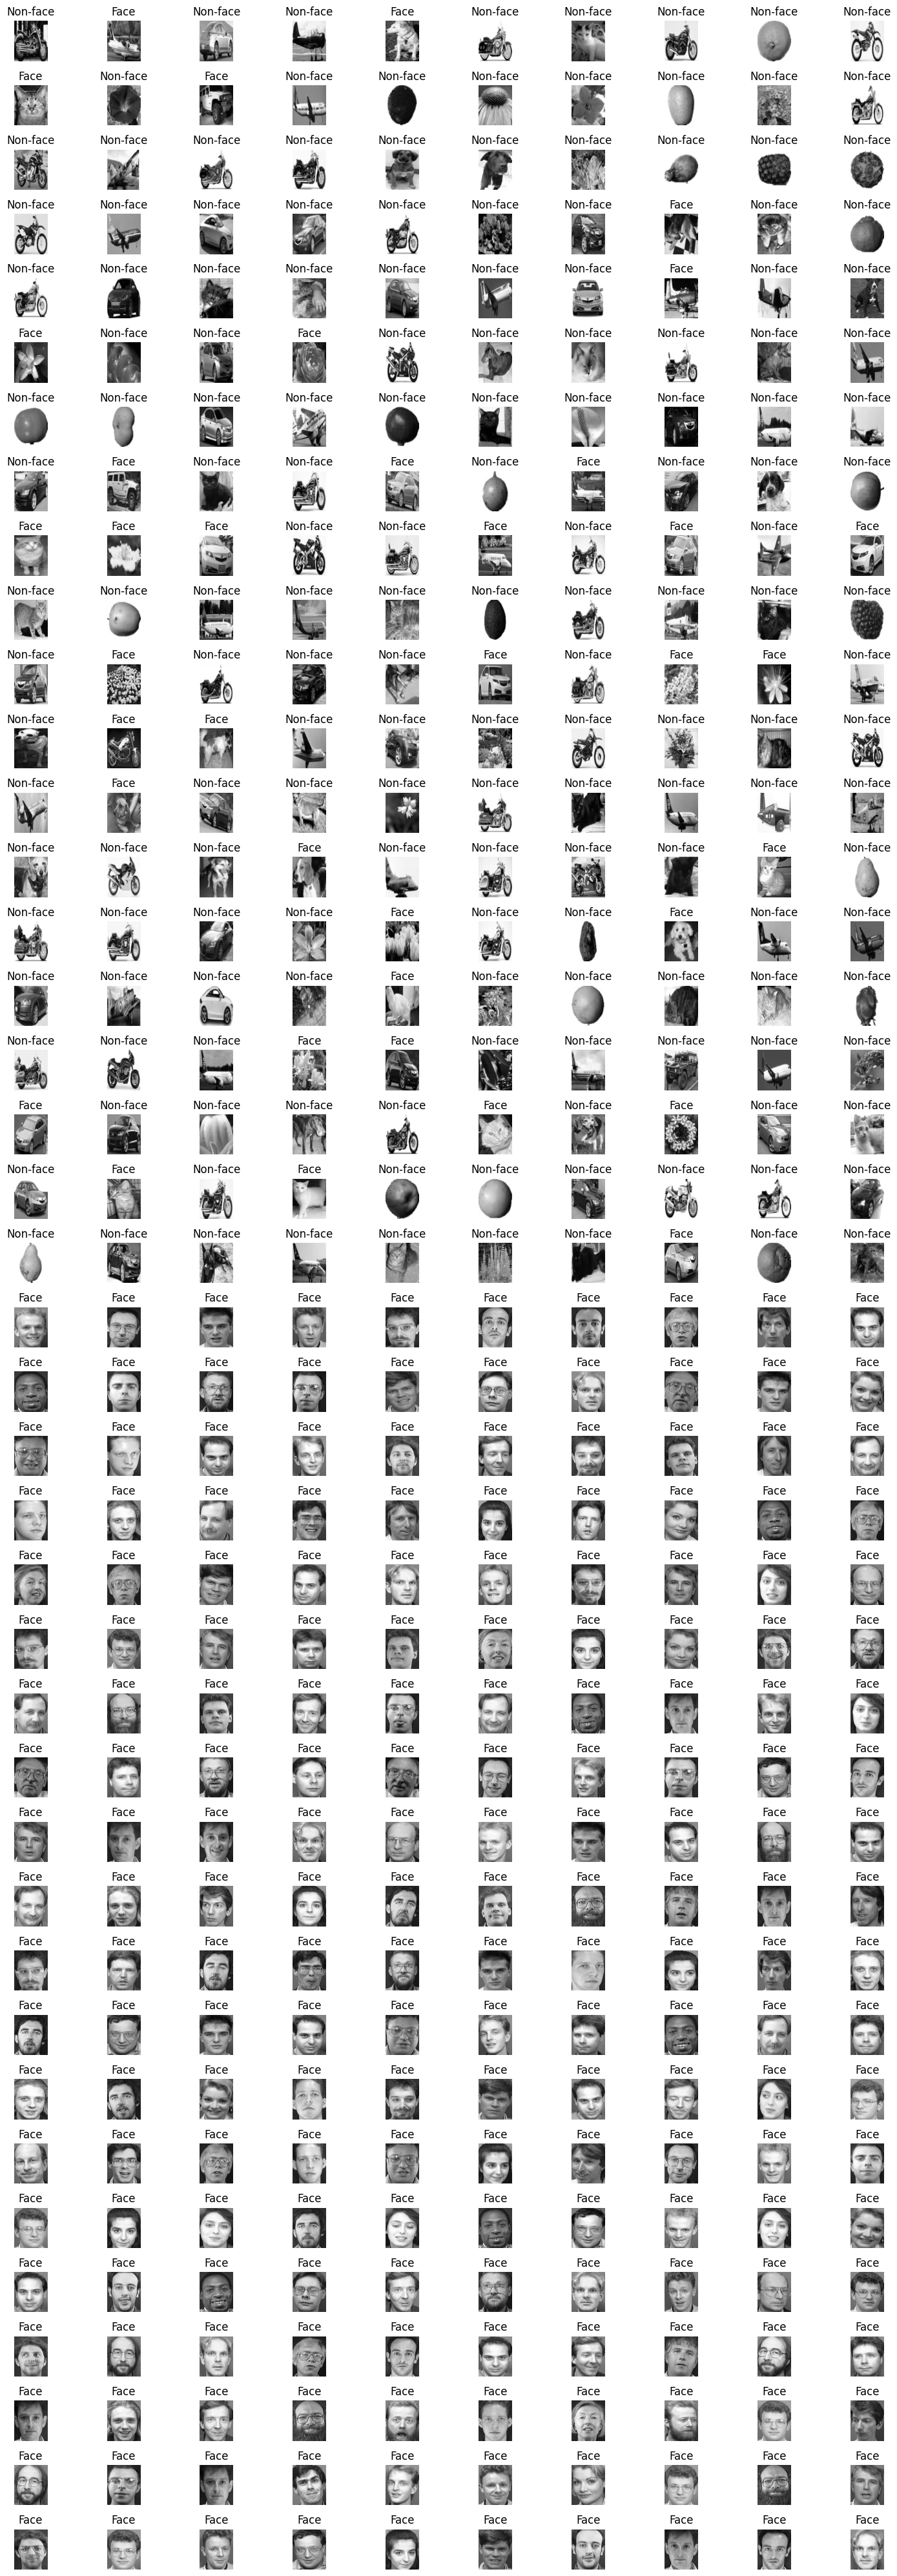

In [35]:
visualize_data_with_labels(X_test_combined, ret_pca[2], 40, 10, 112, 92)

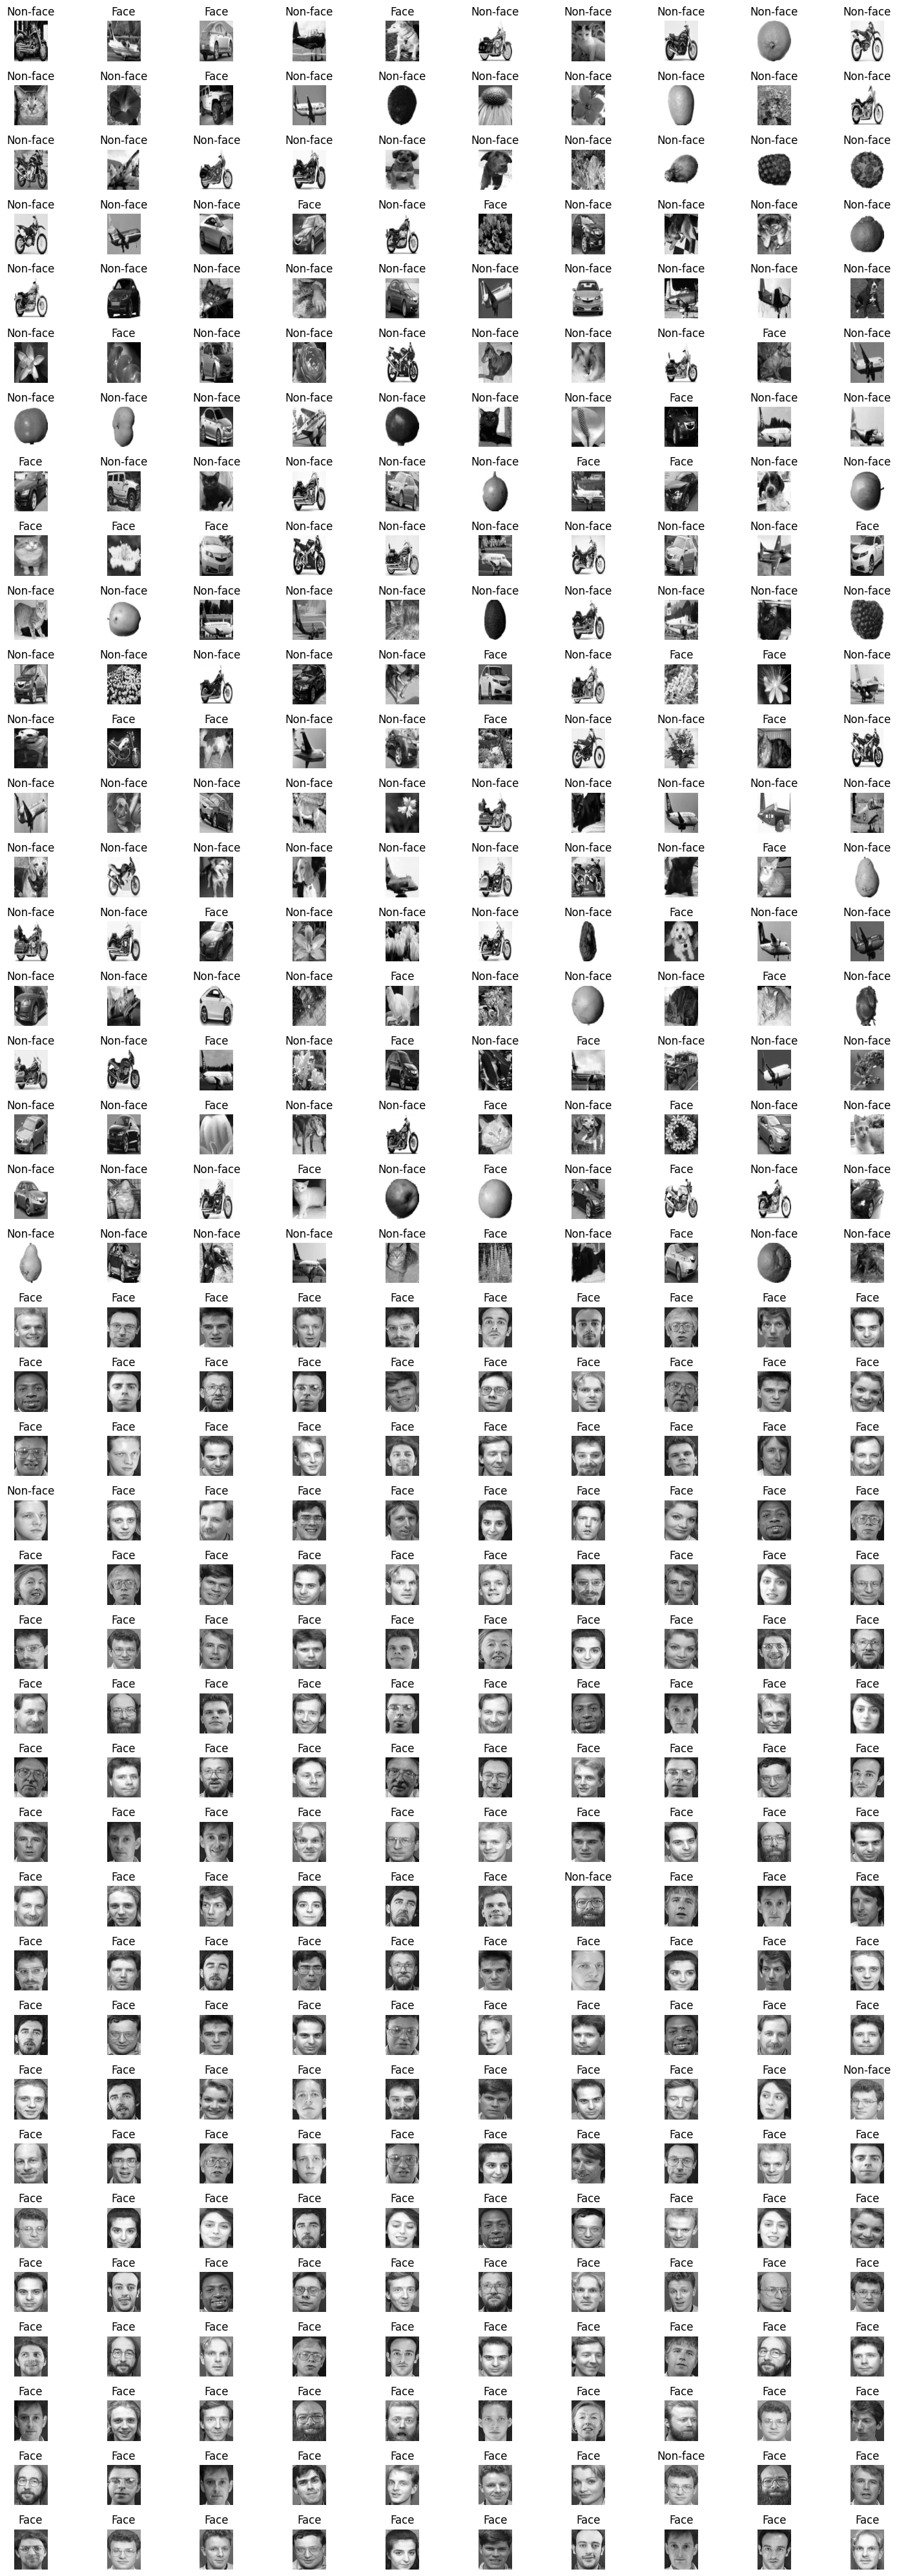

In [36]:
visualize_data_with_labels(X_test_combined, ret_lda[1], 40, 10, 112, 92)

ii) How many dominant eigenvectors will you use for the LDA
solution?

**Answer: Number of dominant eigenvectors = number of classes - 1 = 2 - 1 = 1**

iii) Plot the accuracy vs the number of non-faces images while fixing
the number of face images.

In [37]:
#set different numbers of non-faces test set
def get_accuracies_PCA(num_of_training_non_faces, num_of_test_non_faces, num_of_training_faces, num_of_test_faces):
    accuracies = []
    for num_test_data in num_of_test_non_faces:
        X_train_combined, y_train_combined, X_test_combined, y_test_combined = select_random_items(combined_vectors, combined_y, num_of_training_non_faces, num_test_data, num_of_training_faces, num_of_test_faces)
        ret = get_PCA_accuracy_for_different_ks_and_alphas(X_train_combined, X_test_combined, y_train_combined, y_test_combined, [0.9], [1])
        accuracies.append(ret[0])
    return accuracies


def get_accuracies_LDA(num_of_training_non_faces, num_of_test_non_faces, num_of_training_faces, num_of_test_faces):
    accuracies = []
    for num_test_data in num_of_test_non_faces:
        X_train_combined, y_train_combined, X_test_combined, y_test_combined = select_random_items(combined_vectors, combined_y, num_of_training_non_faces, num_test_data, num_of_training_faces, num_of_test_faces)
        ret = get_LDA_accuracy_for_different_ks(X_train_combined, X_test_combined, y_train_combined, y_test_combined, [1])
        accuracies.append(ret[0])
    return accuracies

In [38]:
num_test_data = [50, 100, 150, 200]
# changing the test set
accuracies_pca = get_accuracies_PCA(200, num_test_data, 200, 200)
accuracies_lda = get_accuracies_LDA(200, num_test_data, 200, 200)

Time of step 1 in 0.016s
Time of step 2 in 2.447s
Time of step 3 in 3.841s
Time of step 4 in 1586.792s
Time in 1593.550s
Time of step 1 in 0.016s
Time of step 2 in 2.144s
Time of step 3 in 3.633s
Time of step 4 in 1584.380s
Time in 1590.642s
Time of step 1 in 0.021s
Time of step 2 in 2.136s
Time of step 3 in 4.666s
Time of step 4 in 1603.015s
Time in 1610.517s
Time of step 1 in 0.023s
Time of step 2 in 2.675s
Time of step 3 in 3.860s
Time of step 4 in 1831.290s
Time in 1838.714s


Text(0.5, 1.0, 'Different non-faces test data Vs Test Accuracy of Classififcation')

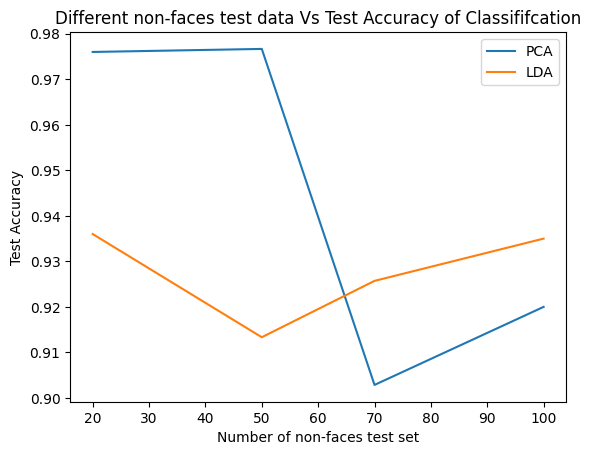

In [61]:
plt.plot(num_test_data, accuracies_pca, label='PCA')
plt.plot(num_test_data, accuracies_lda, label = 'LDA')
plt.xlabel("Number of non-faces test set")
plt.ylabel("Test Accuracy")
plt.legend()
plt.title("Different non-faces test data Vs Test Accuracy of Classififcation")

iv) Criticize the accuracy measure for large numbers of non-faces
images in the training data.

In [41]:
num_test_data = [20, 50, 70, 100]
#Change the test set with large number of non-faces training data
accuracies_pca_large = get_accuracies_PCA(300, num_test_data, 200, 200)
accuracies_lda_large = get_accuracies_LDA(300, num_test_data, 200, 200)

Time of step 1 in 0.036s
Time of step 2 in 3.782s
Time of step 3 in 6.215s
Time of step 4 in 1819.001s
Time in 1829.548s
Time of step 1 in 0.024s
Time of step 2 in 2.408s
Time of step 3 in 5.034s
Time of step 4 in 1751.223s
Time in 1759.390s
Time of step 1 in 0.030s
Time of step 2 in 3.325s
Time of step 3 in 4.955s
Time of step 4 in 1989.245s
Time in 1998.190s
Time of step 1 in 0.034s
Time of step 2 in 2.639s
Time of step 3 in 5.472s
Time of step 4 in 1812.357s
Time in 1821.201s


Text(0.5, 1.0, '(PCA) Different non-faces test data Vs Test Accuracy of Classififcation')

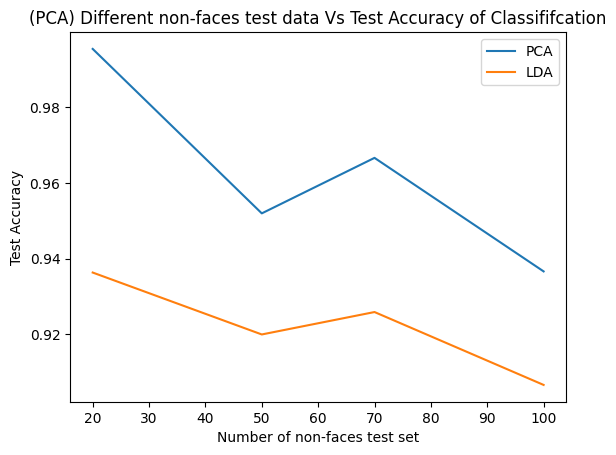

In [63]:
plt.plot(num_test_data, accuracies_pca_large, label='PCA')
plt.plot(num_test_data, accuracies_lda_large, label='LDA')
plt.xlabel("Number of non-faces test set")
plt.ylabel("Test Accuracy")
plt.legend()
plt.title("(PCA) Different non-faces test data Vs Test Accuracy of Classififcation")

In [44]:
# import matplotlib.pyplot as plt

# def visualize(num_rows, num_columns, data, labels):
#     """
#     Visualizes images along with their labels.

#     Parameters:
#     - num_rows: Number of rows in the subplot grid.
#     - num_columns: Number of columns in the subplot grid.
#     - data: Array containing images to be visualized.
#     - labels: Array containing corresponding labels for the images.

#     """
#     image_height = 5
#     image_width = 5

#   # Calculate the total size of the figure
#     figsize = (image_width * num_columns, image_height * num_rows)

#     # Create a subplot with the specified number of rows and columns
#     fig, axes = plt.subplots(num_rows, num_columns, figsize=figsize)

#     # Loop through the data and plot each image
#     for i in range(num_rows):
#         for j in range(num_columns):
#             # Get the image and label from the data
#             image = data[i, j]
#             label = labels[i * num_columns + j]

#             # Plot the image
#             axes[i, j].imshow(image, cmap='gray')
#             axes[i, j].axis('off')
#             axes[i, j].set_title('Label: {}'.format(label))  # Set title as the label

#     plt.tight_layout()
#     plt.show()

# # Example usage:
# # Assuming you have defined num_rows, num_columns, combined_dataset, and combined_y
# visualize(80, 10, combined_dataset, combined_y)


## Different Splitting Ratio

Use different Training and Test splits. Change the number of
instances per subject to be 7 and keep 3 instances per subject for testing.

compare the results you have with the ones you got earlier with 50%
split.

In [45]:
# New split ratio
num_train_instances = 7
num_test_instances = num_poses - num_train_instances

# Split the dataset into training and test sets
X_train = []
X_test = []
y_train = []
y_test = []

# Split the dataset
for i in range(num_subjects):
    X_train.extend(D[i * num_poses : i * num_poses + num_train_instances])
    X_test.extend(D[i * num_poses + num_train_instances : (i + 1) * num_poses])
    y_train.extend(y[i * num_poses : i * num_poses + num_train_instances])
    y_test.extend(y[i * num_poses + num_train_instances : (i + 1) * num_poses])

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [46]:
X_train.shape

(280, 10304)

### PCA

In [47]:
results2, new_dims2, _ = get_PCA_accuracy_for_different_ks_and_alphas(X_train, X_test, y_train, y_test, alphas, k_values = [1])
print(results2)

[0.9583333333333334, 0.9666666666666667, 0.9666666666666667, 0.95]


Comparing the results obtained from different splitting ratios

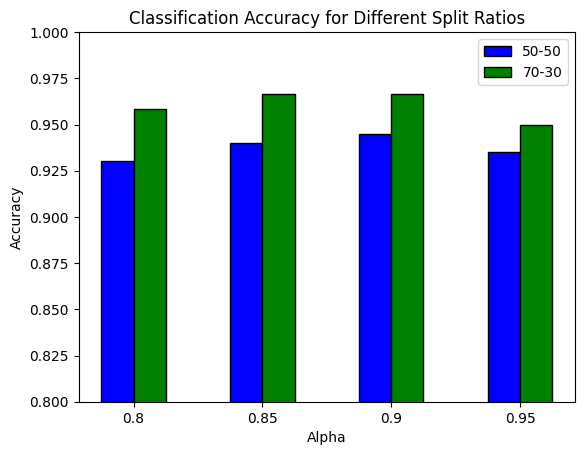

In [48]:
X = alphas

width = 0.25
r = np.arange(len(X))

plt.bar(r, results, color = 'b',
        width = width, edgecolor = 'black',
        label = '50-50')
plt.bar(r + width, results2, color = 'g',
        width = width, edgecolor = 'black',
        label='70-30')

plt.xticks(r + width/2, X)
plt.ylim(0.8, 1)
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Classification Accuracy for Different Split Ratios")
plt.legend()
plt.show()


### LDA

In [50]:
accuracies = get_LDA_accuracy_for_different_ks(X_train, X_test, y_train, y_test, k_values = [1])
print("LDA Accuracy for 70-30 splitting: ", accuracies[0])

Time of step 1 in 0.023s


KeyboardInterrupt: 

## Comparison between different PCA models

Comparing the time complexity and accuracy between our PCA algorithm and that of the sickit-learn library: PCA, IncrementalPCA and KernelPCA.


**References:**

- [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

- [IncrementalPCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html#sklearn.decomposition.IncrementalPCA)

- [KernelPCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA)

- [Variations of PCA](https://www.geeksforgeeks.org/python-variations-of-principal-component-analysis/)

- [SVD vs. EIG](https://harjot-dadhwal.medium.com/why-should-you-prefer-svd-over-eig-while-performing-linear-principal-component-analysis-36a84db3ba4b)



In [51]:
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.model_selection import train_test_split
from time import time

In [52]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(D, y)

In [53]:
algorithms = ['Our PCA', 'Sklearn PCA', 'Incremental PCA', 'Kernel PCA']
computation_time = []
accuracies = []
n_neighbours = 10

Run our PCA:

In [54]:
t0 = time()
accuracy_results, _, _ = get_PCA_accuracy_for_different_ks_and_alphas(X_train,
                                                                      X_test,
                                                                      y_train,
                                                                      y_test,
                                                                      alphas=[0.9],
                                                                      k_values=np.arange(1, n_neighbours+1))
# Save results
computation_time.append((time() - t0))
accuracies.append(accuracy_results)

Run sklearn library's algorithms:

In [55]:
# Initialize models
n_components = new_dims[2] # Corresponds to the selected alpha
sk_pca = PCA(n_components=n_components)
ipca = IncrementalPCA(n_components=n_components, batch_size=n_components)
kpca = KernelPCA(n_components=n_components)
models = [sk_pca, ipca, kpca]

In [56]:
for model in models:
  t0 = time()
  model.fit(X_train)

  # Run KNN classifier on the transformed data
  accuracy_results = []
  for k in range(1, n_neighbours + 1):
    acc, _= classify(knn(k), model.transform(X_train), y_train, model.transform(X_test), y_test)
    accuracy_results.append(acc)

  # Save results
  computation_time.append((time() - t0))
  accuracies.append(accuracy_results)

Plot the results:

In [57]:
print("Time for our PCA:         %0.3fs" % computation_time[0])
print("Time for sklearn PCA:     %0.3fs" % computation_time[1])
print("Time for incremental PCA: %0.3fs" % computation_time[2])
print("Time for kernel PCA:      %0.3fs" % computation_time[3])

Time for our PCA:         107.873s
Time for sklearn PCA:     2.755s
Time for incremental PCA: 5.082s
Time for kernel PCA:      4.909s


In [58]:
accuracies

[[0.96, 0.91, 0.92, 0.92, 0.81, 0.77, 0.78, 0.75, 0.74, 0.69],
 [0.96, 0.91, 0.92, 0.91, 0.83, 0.78, 0.78, 0.75, 0.7, 0.66],
 [0.95, 0.9, 0.92, 0.9, 0.83, 0.77, 0.79, 0.76, 0.71, 0.67],
 [0.95, 0.9, 0.92, 0.91, 0.84, 0.8, 0.78, 0.74, 0.7, 0.66]]

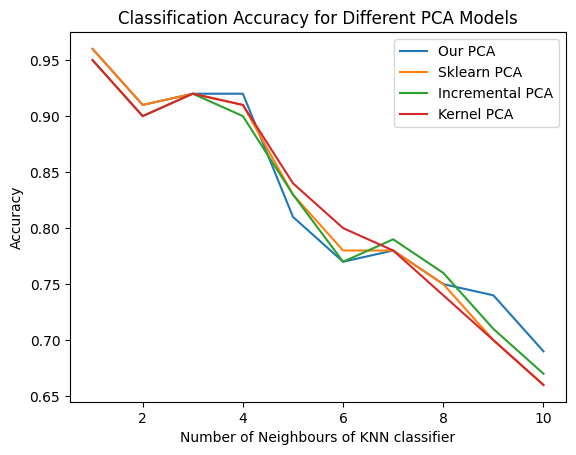

In [59]:
for i, algorithm in enumerate(algorithms):
  plt.plot(np.arange(1, n_neighbours+1), accuracies[i], label = algorithm)

plt.xlabel("Number of Neighbours of KNN classifier")
plt.ylabel("Accuracy")
plt.title("Classification Accuracy for Different PCA Models")
plt.legend()
plt.show()

## Comparison between different LDA models

There are alot of solvers one of them is :-
‘svd’: Singular value decomposition (default). Does not compute the covariance matrix, therefore this solver is recommended for data with a large number of features.

**References:**

[LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)

In [60]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time()

lda_svd = LinearDiscriminantAnalysis(solver='svd')
lda_svd.fit(X_train, y_train)
y_pred_lda = lda_svd.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_lda)

print("Time in %0.3fs" % (time() - t0))
print("Accuracy of svd : ",accuracy)

Time in 3.546s
Accuracy of svd :  0.94
